In [39]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import numpy as np
from tqdm.notebook import tqdm
from functools import wraps
import warnings

def check_nan_inf(array, name="array"):
    """Check if array contains NaN or Inf values."""
    has_nan = jnp.any(jnp.isnan(array))
    has_inf = jnp.any(jnp.isinf(array))
    if has_nan or has_inf:
        warnings.warn(f"{name} contains NaN: {has_nan}, Inf: {has_inf}")
        return True
    return False

def validate_probability_matrix(P, name="matrix", axis=None, tolerance=1e-6):
    """
    Validate that a matrix represents valid probabilities.
    
    Parameters:
    -----------
    P : jnp.ndarray
        Probability matrix to validate
    name : str
        Name for debugging messages
    axis : int or None
        Axis along which probabilities should sum to 1
    tolerance : float
        Tolerance for sum check
    """
    issues = []
    
    # Check for NaN/Inf
    if check_nan_inf(P, name):
        issues.append(f"{name} contains NaN or Inf values")
    
    # Check for negative values
    if jnp.any(P < 0):
        min_val = jnp.min(P)
        issues.append(f"{name} contains negative values (min: {min_val})")
    
    # Check for values > 1
    if jnp.any(P > 1 + tolerance):
        max_val = jnp.max(P)
        issues.append(f"{name} contains values > 1 (max: {max_val})")
    
    # Check sum constraint if axis specified
    if axis is not None:
        sums = jnp.sum(P, axis=axis)
        if not jnp.allclose(sums, 1.0, atol=tolerance):
            min_sum = jnp.min(sums)
            max_sum = jnp.max(sums)
            issues.append(f"{name} sums along axis {axis} not equal to 1 (range: [{min_sum}, {max_sum}])")
    
    if issues:
        print(f"Validation issues for {name}:")
        for issue in issues:
            print(f"  - {issue}")
        return False
    return True

def debug_calculate_mutual_information(E_i, D_j, P_m=None):
    """
    Debug version of mutual information calculation with checks.
    """
    print("\n=== Debug Mutual Information Calculation ===")
    
    # Validate inputs
    print("Checking inputs...")
    validate_probability_matrix(E_i, "Encoder E_i", axis=0)
    validate_probability_matrix(D_j, "Decoder D_j", axis=0)
    
    num_symbols, num_messages = E_i.shape
    
    if P_m is None:
        P_m = jnp.ones(num_messages) / num_messages
    else:
        validate_probability_matrix(P_m.reshape(1, -1), "Prior P_m", axis=1)
    
    # Compute composite channel matrix
    C_ij = D_j @ E_i
    print(f"\nComposite channel C_ij shape: {C_ij.shape}")
    validate_probability_matrix(C_ij, "Composite channel C_ij", axis=0)
    
    # Compute joint probability
    P_joint = C_ij * P_m[jnp.newaxis, :]
    print(f"Joint probability P_joint shape: {P_joint.shape}")
    print(f"P_joint sum: {jnp.sum(P_joint)} (should be 1.0)")
    
    # Check for zeros that might cause log issues
    num_zeros = jnp.sum(P_joint == 0)
    print(f"Number of exact zeros in P_joint: {num_zeros}")
    if num_zeros > 0:
        print("  Warning: Zeros in joint probability may cause numerical issues")
    
    # Compute marginals
    P_m_prime = jnp.sum(P_joint, axis=1)
    print(f"\nMarginal P(m') range: [{jnp.min(P_m_prime)}, {jnp.max(P_m_prime)}]")
    
    # Check marginal product
    P_marginal_product = jnp.outer(P_m_prime, P_m)
    print(f"Marginal product range: [{jnp.min(P_marginal_product)}, {jnp.max(P_marginal_product)}]")
    
    # Check for potential division issues
    zero_marginal_product = jnp.sum(P_marginal_product == 0)
    print(f"Zeros in marginal product: {zero_marginal_product}")
    
    # Compute MI with detailed checks
    epsilon = 1e-10
    log_ratio = P_joint / (P_marginal_product + epsilon)
    
    print(f"\nLog ratio range: [{jnp.min(log_ratio)}, {jnp.max(log_ratio)}]")
    check_nan_inf(log_ratio, "log_ratio")
    
    # Use safe log computation
    mutual_info = jnp.sum(jax.scipy.special.xlogy(P_joint, log_ratio))
    
    print(f"\nMutual information: {mutual_info}")
    check_nan_inf(mutual_info, "mutual_info")
    
    # Normalize
    H_M = -jnp.sum(jax.scipy.special.xlogy(P_m, P_m))
    print(f"Entropy H(M): {H_M}")
    
    return mutual_info

def safe_normalize_decoder(D, epsilon=1e-10):
    """
    Safely normalize decoder matrix with small epsilon to prevent division by zero.
    """
    col_sums = jnp.sum(D, axis=0, keepdims=True)
    
    # Check for zero columns
    zero_cols = jnp.sum(col_sums == 0)
    if zero_cols > 0:
        warnings.warn(f"Decoder has {zero_cols} columns that sum to zero!")
    
    # Add epsilon to prevent division by zero
    D_normalized = D / (col_sums + epsilon)
    
    # Renormalize to ensure exact sum to 1
    D_normalized = D_normalized / jnp.sum(D_normalized, axis=0, keepdims=True)
    
    return D_normalized

def safe_gen_optimal_encoder(D, epsilon=1e-10):
    """
    Generate optimal encoder with numerical safety checks.
    """
    M, S = D.shape
    
    # Validate decoder
    if not validate_probability_matrix(D, "Decoder in gen_optimal_encoder", axis=0):
        print("Warning: Invalid decoder matrix!")
    
    # Compute marginal P(s) under uniform P(m)
    P_m = 1.0 / M
    P_s = jnp.sum(D * P_m, axis=0)
    
    # Check for zero probabilities
    zero_probs = jnp.sum(P_s == 0)
    if zero_probs > 0:
        warnings.warn(f"P(s) has {zero_probs} zero entries!")
    
    # Compute encoder with safety
    numerator = D.T * P_s[:, jnp.newaxis]
    denominator = jnp.sum(D * P_s[jnp.newaxis, :], axis=1) + epsilon
    
    # Check for potential issues
    if jnp.any(denominator == epsilon):
        warnings.warn("Some denominators in encoder computation are effectively zero!")
    
    E = numerator / denominator[jnp.newaxis, :]
    
    # Validate output
    validate_probability_matrix(E, "Generated encoder", axis=0)
    
    return E

def debug_update(D, E_arr, learning_rate=0.01, v=None):
    """
    Debug version of update function with extensive checking.
    """
    print("\n=== Debug Update Function ===")
    
    # Check initial decoder
    print("Initial decoder check:")
    validate_probability_matrix(D, "Initial D", axis=0)
    
    # Check encoders
    for i, E in enumerate(E_arr):
        validate_probability_matrix(E, f"Encoder {i}", axis=0)
    
    # Compute gradient with checks
    grad_D = info_grad(D, E_arr, v)
    print(f"\nGradient stats:")
    print(f"  Shape: {grad_D.shape}")
    print(f"  Range: [{jnp.min(grad_D)}, {jnp.max(grad_D)}]")
    print(f"  Norm: {jnp.linalg.norm(grad_D)}")
    check_nan_inf(grad_D, "Gradient")
    
    # Check if gradient is too large
    if jnp.linalg.norm(grad_D) > 100:
        warnings.warn(f"Large gradient norm: {jnp.linalg.norm(grad_D)}")
    
    # Update step
    D_new = D + learning_rate * grad_D
    print(f"\nAfter gradient step:")
    print(f"  D_new range: [{jnp.min(D_new)}, {jnp.max(D_new)}]")
    
    # Check for negative values before normalization
    if jnp.any(D_new < 0):
        neg_count = jnp.sum(D_new < 0)
        warnings.warn(f"D_new has {neg_count} negative values before normalization!")
    
    # Normalize
    D_normalized = safe_normalize_decoder(D_new)
    
    print("\nAfter normalization:")
    validate_probability_matrix(D_normalized, "Normalized D", axis=0)
    
    return D_normalized

def add_nan_checking(func):
    """Decorator to add NaN checking to functions."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        # Check inputs
        for i, arg in enumerate(args):
            if isinstance(arg, jnp.ndarray):
                if check_nan_inf(arg, f"Input arg {i} to {func.__name__}"):
                    print(f"NaN/Inf detected in input to {func.__name__}!")
        
        # Run function
        result = func(*args, **kwargs)
        
        # Check output
        if isinstance(result, jnp.ndarray):
            if check_nan_inf(result, f"Output of {func.__name__}"):
                print(f"NaN/Inf detected in output of {func.__name__}!")
        elif isinstance(result, (list, tuple)):
            for i, res in enumerate(result):
                if isinstance(res, jnp.ndarray):
                    if check_nan_inf(res, f"Output {i} of {func.__name__}"):
                        print(f"NaN/Inf detected in output {i} of {func.__name__}!")
        
        return result
    return wrapper

def diagnose_convergence_step(decoders, encoders, iteration, learning_rate=0.01):
    """
    Detailed diagnosis of a single convergence step.
    """
    print(f"\n{'='*60}")
    print(f"DIAGNOSING ITERATION {iteration}")
    print(f"{'='*60}")
    
    N = len(decoders)
    
    # Check all current decoders and encoders
    for i in range(N):
        print(f"\nAgent {i}:")
        valid_d = validate_probability_matrix(decoders[i], f"Decoder {i}", axis=0)
        valid_e = validate_probability_matrix(encoders[i], f"Encoder {i}", axis=0) 
        
        if not valid_d or not valid_e:
            print(f"  WARNING: Agent {i} has invalid matrices!")
    
    # Compute mutual information matrix
    mi_matrix = jnp.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i != j:
                try:
                    mi = calculate_mutual_information_jax(encoders[j], decoders[i])
                    mi_matrix = mi_matrix.at[i, j].set(mi)
                    
                    if jnp.isnan(mi) or jnp.isinf(mi):
                        print(f"\nNaN/Inf detected in MI({i},{j})!")
                        print(f"Running detailed debug...")
                        debug_calculate_mutual_information(encoders[j], decoders[i])
                except Exception as e:
                    print(f"\nError computing MI({i},{j}): {e}")
    
    print(f"\nMutual Information Matrix:")
    print(f"  Contains NaN: {jnp.any(jnp.isnan(mi_matrix))}")
    print(f"  Contains Inf: {jnp.any(jnp.isinf(mi_matrix))}")
    print(f"  Range: [{jnp.min(mi_matrix[mi_matrix > 0])}, {jnp.max(mi_matrix)}]")
    
    # Test one update step
    print(f"\nTesting update for agent 0...")
    other_encoders = [encoders[j] for j in range(N) if j != 0]
    D_new = debug_update(decoders[0], other_encoders, learning_rate)
    
    return mi_matrix

def gen_D_binary(S, M, key=None):
    """Generate a decoder matrix D where D[m,s] = P(m|s)"""
    if key is None:
        key = jax.random.PRNGKey(0)
    
    D = jnp.zeros((M, S))
    for col in range(S):
        subkey1, subkey2, key = jax.random.split(key, 3)
        # For each symbol, randomly assign probabilities to messages
        num_messages = jax.random.randint(subkey1, (), 1, M+1)
        selected_messages = jax.random.choice(subkey2, M, shape=(M,), replace=True)
        unique_messages = jnp.unique(selected_messages[:num_messages])
        D = D.at[unique_messages, col].set(1.0 / len(unique_messages))
    return D

def gen_optimal_encoder(D):
    """
    Generate the optimal encoder E given decoder D.
    D: (M, S) matrix where D[m,s] = P(m|s)
    Returns E: (S, M) matrix where E[s,m] = P(s|m)
    """
    M, S = D.shape
    
    # Compute marginal P(s) under uniform P(m) = 1/M
    P_m = 1.0 / M
    P_s = jnp.sum(D * P_m, axis=0)  # P(s) = sum_m P(m|s)P(m)
    
    # Compute encoder using Bayes rule
    # E(s|m) = D(m|s)P(s) / sum_s' D(m|s')P(s')
    # Vectorized computation
    numerator = D.T * P_s[:, jnp.newaxis]  # (S, M)
    denominator = jnp.sum(D * P_s[jnp.newaxis, :], axis=1)  # (M,)
    E = numerator / (denominator[jnp.newaxis, :])
    
    return E

@jit
def calculate_mutual_information_jax(E_i, D_j, P_m=None):
    """
    JAX-compatible calculation of normalized mutual information.
    
    Parameters:
    -----------
    E_i : jnp.ndarray
        Encoder matrix for agent i, shape (|S|, |M|) where E_i[s,m] = P(s|m)
    D_j : jnp.ndarray  
        Decoder matrix for agent j, shape (|M|, |S|) where D_j[m',s] = P(m'|s)
    P_m : jnp.ndarray, optional
        Prior distribution over messages, shape (|M|,). If None, assumes uniform.
    
    Returns:
    --------
    I_ij_normalized : float
        Normalized mutual information I(M_i; M_j')/H(M), in range [0,1]
    """
    
    # Get dimensions
    num_symbols, num_messages = E_i.shape
    
    # Set uniform prior if not provided
    if P_m is None:
        P_m = jnp.ones(num_messages) / num_messages
    
    # Compute composite channel matrix C_ij
    C_ij = D_j @ E_i
    
    # Compute joint probability matrix
    P_joint = C_ij * P_m[jnp.newaxis, :]
    
    # Compute marginal P(m')
    P_m_prime = jnp.sum(P_joint, axis=1)
    
    # Compute mutual information using vectorized operations
    epsilon = 1e-10
    # Create outer product of marginals
    P_marginal_product = jnp.outer(P_m_prime, P_m)

    # TODO: is this logic actually robust to p=0?
    # Compute MI with numerical stability
    # Using xlogy for x * log(y) which handles x=0 case properly
    log_ratio = P_joint / (P_marginal_product + epsilon)
    mutual_info = jnp.sum(jax.scipy.special.xlogy(P_joint, log_ratio))
    
    # Normalize by entropy of M
    # H_M = jnp.sum(P_m * jnp.log(P_m))
    # I_ij_normalized = mutual_info / H_M
    
    return mutual_info

def mutual_info_sum(D, E_arr, v=None):
    """
    Calculate weighted sum of mutual information for decoder D with multiple encoders.
    
    Parameters:
    -----------
    D : jnp.ndarray
        Decoder matrix, shape (|M|, |S|)
    E_arr : list of jnp.ndarray
        List of encoder matrices, each shape (|S|, |M|)
    v : jnp.ndarray, optional
        Weights for each encoder, default is uniform
    
    Returns:
    --------
    weighted_sum : float
        Weighted sum of mutual information values
    """
    n = len(E_arr)
    if v is None:
        v = jnp.ones(n) / n
    
    # Stack encoders for vectorized computation
    E_stack = jnp.stack(E_arr, axis=0)  # (n, |S|, |M|)
    
    # Vectorized mutual information calculation
    vmap_mi = vmap(lambda E: calculate_mutual_information_jax(E, D))
    mi_values = vmap_mi(E_stack)
    
    return jnp.sum(v * mi_values)

def info_grad(D, E_arr, v=None):
    """
    Compute gradient of mutual information sum with respect to decoder D.
    
    Parameters:
    -----------
    D : jnp.ndarray  
        Decoder matrix for agent j, shape (|M|, |S|) where D_j[m',s] = P(m'|s)
    E_arr : list[jnp.ndarray] of length n
        List of encoder matrices for agent i, shape (|S|, |M|) where E_i[s,m] = P(s|m)
    v : jnp.ndarray
        A n-vector of weights to prioritize the mutual information from different channels
        default = uniform weights
    
    Returns:
    --------
    grad_D: jnp.ndarray
        The gradient of the weighted mutual information sum with respect to D
    """
    # Create gradient function
    grad_fn = grad(mutual_info_sum, argnums=0)
    
    # Compute gradient
    grad_D = grad_fn(D, E_arr, v)
    
    return grad_D

def normalize_decoder(D):
    """
    Normalize decoder matrix so columns sum to 1.
    """
    return (D + 1e-10) / (jnp.sum(D + 1e-10, axis=0, keepdims=True))

def update(D, E_arr, learning_rate=0.01, v=None):
    """
    Update decoder D to maximize weighted mutual information from encoders E_arr.
    
    Parameters:
    -----------
    D : jnp.ndarray
        Current decoder matrix
    E_arr : list[jnp.ndarray]
        List of encoder matrices to receive from
    learning_rate : float
        Step size for gradient ascent
    v : jnp.ndarray, optional
        Weights for each encoder
    
    Returns:
    --------
    D_new : jnp.ndarray
        Updated and normalized decoder matrix
    """
    # Compute gradient
    grad_D = info_grad(D, E_arr, v)
    
    # Gradient ascent step
    D_new = D + learning_rate * grad_D

    # Set any negative values to 0
    D_new = jnp.maximum(D_new, 0.0)
    
    # Project back to probability simplex by normalization
    D_new = normalize_decoder(D_new)
    
    return D_new

# Additional utilities for the full system

def initialize_agents(N, S, M, key=None):
    """
    Initialize N agents with random decoders and optimal encoders.
    
    Parameters:
    -----------
    N : int
        Number of agents
    S : int
        Size of shared symbol space
    M : int
        Size of message space
    key : jax.random.PRNGKey
        Random key for initialization
    
    Returns:
    --------
    decoders : list of jnp.ndarray
        List of decoder matrices
    encoders : list of jnp.ndarray
        List of optimal encoder matrices
    """
    if key is None:
        key = jax.random.PRNGKey(0)
    
    decoders = []
    encoders = []
    
    for i in range(N):
        key, subkey = jax.random.split(key)
        # Initialize random decoder
        D = jax.random.uniform(subkey, (M, S))
        D = normalize_decoder(D)
        decoders.append(D)
        
        # Compute optimal encoder
        E = gen_optimal_encoder(D)
        encoders.append(E)
    
    return decoders, encoders

def simulate_convergence(N, S, M, num_iterations=100, learning_rate=0.01, key=None, home_planet=False):
    """
    Simulate the convergence of the multi-agent language system.
    
    Parameters:
    -----------
    N : int
        Number of agents
    S : int
        Size of shared symbol space
    M : int
        Size of message space
    num_iterations : int
        Number of update iterations
    learning_rate : float
        Learning rate for decoder updates
    key : jax.random.PRNGKey
        Random key for initialization
    
    Returns:
    --------
    history : dict
        Dictionary containing evolution history
    """
    # Initialize agents
    decoders, encoders = initialize_agents(N, S, M, key)
    
    # Track history
    history = {
        'mutual_info': [],
        'decoders': [decoders],
        'encoders': [encoders]
    }
    
    for iteration in tqdm(range(num_iterations)):
        # Update each agent's decoder
        new_decoders = []
        new_encoders = []
        
        for i in range(N):
            # Get encoders from all other agents
            other_encoders = [encoders[j] for j in range(N) if j != i]

            if home_planet:
                other_encoders.append(history['encoders'][0][i]) # Also optimize for mutual info with original language
            
            # Update decoder
            D_new = update(decoders[i], other_encoders, learning_rate)
            new_decoders.append(D_new)
            
            # Compute new optimal encoder
            E_new = gen_optimal_encoder(D_new)
            new_encoders.append(E_new)
        
        decoders = new_decoders
        encoders = new_encoders
        
        # Record mutual information matrix
        mi_matrix = jnp.zeros((N, N))
        for i in range(N):
            for j in range(N):
                if i != j:
                    mi_matrix = mi_matrix.at[i, j].set(
                        calculate_mutual_information_jax(encoders[j], decoders[i])
                    )
        
        history['mutual_info'].append(mi_matrix)
        history['decoders'].append(decoders)
        history['encoders'].append(encoders)
    
    return history

def simulate_convergence_debug(N, S, M, num_iterations=100, learning_rate=0.01, 
                              key=None, home_planet=False, debug_frequency=10):
    """
    Debug version of simulate_convergence with extensive checking.
    
    Parameters:
    -----------
    debug_frequency : int
        How often to print detailed debug info (every N iterations)
    """
    print(f"Starting simulation with N={N}, S={S}, M={M}")
    print(f"Learning rate: {learning_rate}")
    
    # Initialize agents with safety checks
    decoders, encoders = initialize_agents(N, S, M, key)
    
    # Validate initialization
    print("\nValidating initial conditions...")
    all_valid = True
    for i in range(N):
        if not validate_probability_matrix(decoders[i], f"Initial decoder {i}", axis=0):
            all_valid = False
        if not validate_probability_matrix(encoders[i], f"Initial encoder {i}", axis=0):
            all_valid = False
    
    if not all_valid:
        warnings.warn("Initial conditions have validation issues!")
    
    # Track history
    history = {
        'mutual_info': [],
        'decoders': [decoders],
        'encoders': [encoders],
        'nan_iterations': [],  # Track where NaNs appear
        'gradient_norms': []   # Track gradient magnitudes
    }
    
    # Track when issues first appear
    first_nan_iteration = None
    
    for iteration in tqdm(range(num_iterations)):
        # Detailed debug every N iterations or when NaN detected
        do_detailed_debug = (iteration % debug_frequency == 0) or (first_nan_iteration is not None)
        
        if do_detailed_debug:
            print(f"\n{'='*60}")
            print(f"Iteration {iteration}")
            print(f"{'='*60}")
        
        # Update each agent's decoder
        new_decoders = []
        new_encoders = []
        gradient_norms = []
        
        for i in range(N):
            # Get encoders from all other agents
            other_encoders = [encoders[j] for j in range(N) if j != i]
            
            if home_planet:
                other_encoders.append(history['encoders'][0][i])
            
            # Check current decoder before update
            if check_nan_inf(decoders[i], f"Decoder {i} before update"):
                print(f"  NaN detected in decoder {i} at iteration {iteration}")
                if first_nan_iteration is None:
                    first_nan_iteration = iteration
            
            # Compute gradient for monitoring
            grad_D = info_grad(decoders[i], other_encoders)
            grad_norm = jnp.linalg.norm(grad_D)
            gradient_norms.append(grad_norm)
            
            if do_detailed_debug:
                print(f"\nAgent {i} gradient norm: {grad_norm:.4f}")
            
            # Check for exploding gradients
            if grad_norm > 100:
                warnings.warn(f"Large gradient norm {grad_norm} for agent {i} at iteration {iteration}")
            
            # Update decoder with safety
            try:
                if do_detailed_debug and i == 0:  # Detailed debug for first agent
                    D_new = debug_update(decoders[i], other_encoders, learning_rate)
                else:
                    D_new = update(decoders[i], other_encoders, learning_rate)
                
                # Extra safety: clip extreme values
                D_new = jnp.clip(D_new, 1e-10, 1.0)
                D_new = safe_normalize_decoder(D_new)
                
            except Exception as e:
                print(f"Error updating agent {i} at iteration {iteration}: {e}")
                D_new = decoders[i]  # Keep old decoder if update fails
            
            new_decoders.append(D_new)
            
            # Compute new optimal encoder with safety
            try:
                E_new = safe_gen_optimal_encoder(D_new)
            except Exception as e:
                print(f"Error generating encoder for agent {i} at iteration {iteration}: {e}")
                E_new = encoders[i]  # Keep old encoder if generation fails
            
            new_encoders.append(E_new)
        
        decoders = new_decoders
        encoders = new_encoders
        history['gradient_norms'].append(gradient_norms)
        
        # Record mutual information matrix with checks
        mi_matrix = jnp.zeros((N, N))
        nan_found = False
        
        for i in range(N):
            for j in range(N):
                if i != j:
                    try:
                        mi = calculate_mutual_information_jax(encoders[j], decoders[i])
                        
                        if jnp.isnan(mi) or jnp.isinf(mi):
                            nan_found = True
                            print(f"\nNaN/Inf in MI({i},{j}) at iteration {iteration}!")
                            if first_nan_iteration is None:
                                first_nan_iteration = iteration
                                # Run detailed debug
                                debug_calculate_mutual_information(encoders[j], decoders[i])
                        else:
                            mi_matrix = mi_matrix.at[i, j].set(mi)
                            
                    except Exception as e:
                        print(f"Error computing MI({i},{j}) at iteration {iteration}: {e}")
                        nan_found = True
        
        if nan_found:
            history['nan_iterations'].append(iteration)
        
        history['mutual_info'].append(mi_matrix)
        history['decoders'].append(decoders)
        history['encoders'].append(encoders)
        
        # Summary statistics every debug_frequency iterations
        if do_detailed_debug:
            avg_mi = jnp.mean(mi_matrix[mi_matrix > 0]) if jnp.any(mi_matrix > 0) else 0
            max_grad = jnp.max(jnp.array(gradient_norms))
            print(f"\nIteration {iteration} summary:")
            print(f"  Average MI: {avg_mi:.4f}")
            print(f"  Max gradient norm: {max_grad:.4f}")
            print(f"  NaN detected: {nan_found}")
        
        # Early stopping if too many NaNs
        if len(history['nan_iterations']) > 5:
            print(f"\nStopping early due to persistent NaN values")
            break
    
    # Final diagnostic report
    print(f"\n{'='*60}")
    print("SIMULATION COMPLETE - DIAGNOSTIC REPORT")
    print(f"{'='*60}")
    
    if history['nan_iterations']:
        print(f"NaN values detected in iterations: {history['nan_iterations']}")
        print(f"First NaN at iteration: {first_nan_iteration}")
    else:
        print("No NaN values detected!")
    
    # Analyze gradient behavior
    all_grad_norms = jnp.array([jnp.max(jnp.array(g)) for g in history['gradient_norms']])
    print(f"\nGradient norm statistics:")
    print(f"  Mean max gradient: {jnp.mean(all_grad_norms):.4f}")
    print(f"  Max gradient ever: {jnp.max(all_grad_norms):.4f}")
    
    # Check final state
    print(f"\nFinal state check:")
    final_mi = history['mutual_info'][-1] if history['mutual_info'] else None
    if final_mi is not None:
        valid_mi = jnp.sum(~jnp.isnan(final_mi) & (final_mi > 0))
        print(f"  Valid MI entries: {valid_mi}/{N*(N-1)}")
        if valid_mi > 0:
            print(f"  Average final MI: {jnp.mean(final_mi[~jnp.isnan(final_mi) & (final_mi > 0)]):.4f}")
    
    return history

# Additional diagnostic function to analyze where things go wrong
def analyze_nan_source(history):
    """
    Analyze history to determine likely source of NaN values.
    """
    print("\n=== NaN Source Analysis ===")
    
    if not history['nan_iterations']:
        print("No NaN iterations to analyze")
        return
    
    first_nan_iter = history['nan_iterations'][0]
    print(f"First NaN at iteration: {first_nan_iter}")
    
    # Check gradient behavior before NaN
    if first_nan_iter > 0:
        grad_norms_before = history['gradient_norms'][first_nan_iter-1]
        print(f"\nGradient norms before first NaN:")
        for i, norm in enumerate(grad_norms_before):
            print(f"  Agent {i}: {norm:.4f}")
    
    # Check decoders at NaN iteration
    print(f"\nChecking decoders at iteration {first_nan_iter}:")
    for i, decoder in enumerate(history['decoders'][first_nan_iter]):
        col_sums = jnp.sum(decoder, axis=0)
        min_sum = jnp.min(col_sums)
        max_sum = jnp.max(col_sums)
        zero_cols = jnp.sum(col_sums < 1e-10)
        print(f"  Decoder {i}: col_sum range [{min_sum:.6f}, {max_sum:.6f}], zero cols: {zero_cols}")
    
    # Check for specific patterns
    print("\nPossible causes:")
    
    # Check if gradients exploded
    all_grad_norms = jnp.array([jnp.max(jnp.array(g)) for g in history['gradient_norms'][:first_nan_iter]])
    if len(all_grad_norms) > 0 and jnp.max(all_grad_norms) > 50:
        print("  - Gradient explosion detected (max norm > 50)")
        print(f"    Suggestion: Reduce learning rate (current might be too high)")
    
    # Check if decoders became degenerate
    for i, decoder in enumerate(history['decoders'][first_nan_iter]):
        if jnp.any(jnp.sum(decoder, axis=0) < 1e-10):
            print(f"  - Decoder {i} has near-zero columns (degenerate)")
            print(f"    Suggestion: Add regularization or use safe_normalize_decoder")
    
    # Check if it's related to home planet constraint
    if 'home_planet' in history and history.get('home_planet', False):
        print("  - Home planet constraint is active")
        print("    This adds additional constraints that might cause instability")

# Example usage and testing
# Set parameters
N = 10 # Number of agents
S = 3  # Symbol space size
M = 3  # Message space size

# Initialize
key = jax.random.PRNGKey(42)
decoders, encoders = initialize_agents(N, S, M, key)

# Test gradient computation
D_test = decoders[0]
E_test = encoders[1:]

# Compute gradient
grad_D = info_grad(D_test, E_test)
print(f"Gradient shape: {grad_D.shape}")
print(f"Gradient norm: {jnp.linalg.norm(grad_D):.4f}")

# Test update
D_new = update(D_test, E_test, learning_rate=0.1)
print(f"Decoder still normalized: {jnp.allclose(jnp.sum(D_new, axis=0), 1.0)}")

# Run short simulation
history = simulate_convergence(N, S, M, num_iterations=100, learning_rate=0.5, key=key, home_planet=True)

print(f"\nInitial average mutual information: {jnp.mean(history['mutual_info'][0]):.4f}")
print(f"Final average mutual information: {jnp.mean(history['mutual_info'][-1]):.4f}")

Gradient shape: (3, 3)
Gradient norm: 0.0370
Decoder still normalized: True


  0%|          | 0/100 [00:00<?, ?it/s]


Initial average mutual information: 0.0085
Final average mutual information: 0.9888


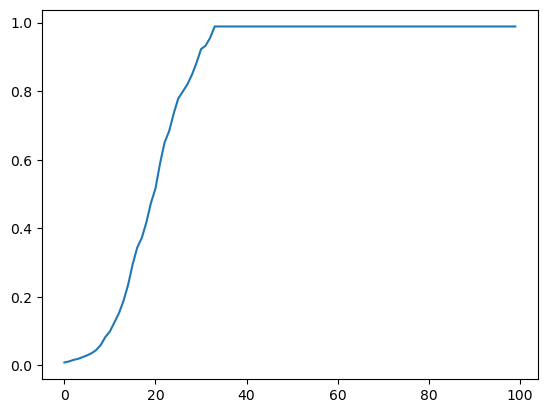

In [40]:
import matplotlib.pyplot as plt

mean_mutual_info = [jnp.mean(i) for i in history['mutual_info']]

plt.plot(mean_mutual_info)

<Axes: >

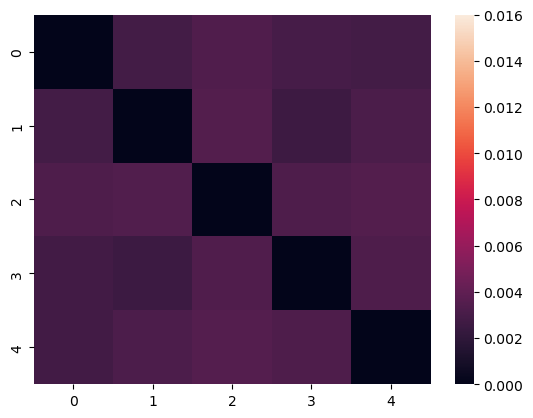

In [27]:
import seaborn as sns

sns.heatmap(history['mutual_info'][0], vmax=0.016)

<Axes: >

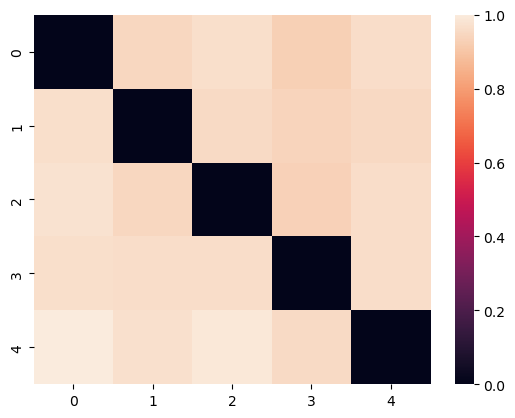

In [29]:
sns.heatmap(history['mutual_info'][75], vmax=1)

In [67]:
import numpy as np

import numpy as np

def gen_D_binary(S, M):
    """Generate a decoder matrix D where D[m,s] = P(m|s)"""
    D = np.zeros((M, S))
    for col in range(S):
        # For each symbol, randomly assign probabilities to messages
        selected_messages = np.random.choice(np.arange(M), size=np.random.randint(1, M+1), replace=True)
        unique_messages = np.unique(selected_messages)
        D[unique_messages, col] = 1.0 / len(unique_messages)
    return D

def gen_optimal_encoder(D):
    """
    Generate the optimal encoder E given decoder D.
    D: (M, S) matrix where D[m,s] = P(m|s)
    Returns E: (S, M) matrix where E[s,m] = P(s|m)
    """
    M, S = D.shape
    
    # Compute marginal P(s) under uniform P(m) = 1/M
    P_m = 1.0 / M
    P_s = np.sum(D * P_m, axis=0)  # P(s) = sum_m P(m|s)P(m)
    
    # Compute encoder using Bayes rule
    # E(s|m) = D(m|s)P(s) / sum_s' D(m|s')P(s')
    E = np.zeros((S, M))
    for m in range(M):
        denominator = np.sum(D[m, :] * P_s)
        if denominator > 0:
            E[:, m] = D[m, :] * P_s / denominator
    
    return E

def test_encoder_optimality(D, E, num_samples=10000):
    """
    Test that the encoder E is optimal for decoder D by:
    1. Verifying it maximizes mutual information I(M; M')
    2. Checking that it minimizes reconstruction error
    """
    M, S = D.shape
    
    # Test 1: Verify the encoder satisfies the Bayes optimal condition
    P_m = 1.0 / M
    P_s = np.sum(D * P_m, axis=0)
    
    for m in range(M):
        denominator = np.sum(D[m, :] * P_s)
        if denominator > 0:
            expected_E = D[m, :] * P_s / denominator
            assert np.allclose(E[:, m], expected_E), f"Encoder doesn't match Bayes optimal for message {m}"
    
    # Test 2: Empirical reconstruction - sample messages and check recovery
    reconstruction_matrix = E.T @ D.T  # P(m'|m) = sum_s P(m'|s)P(s|m)
    
    # For optimal encoder, diagonal should be maximized
    diagonal_sum = np.trace(reconstruction_matrix)
    
    # Compare with random encoder
    random_E = np.random.rand(S, M)
    random_E = random_E / random_E.sum(axis=0, keepdims=True)  # Normalize columns
    random_reconstruction = random_E.T @ D.T
    random_diagonal = np.trace(random_reconstruction)
    
    assert diagonal_sum >= random_diagonal - 1e-6, "Optimal encoder should have better reconstruction than random"
    
    # Test 3: Compute mutual information
    # I(M;M') = sum_m,m' P(m,m') log(P(m,m') / (P(m)P(m')))
    P_joint = np.zeros((M, M))
    for m in range(M):
        for m_prime in range(M):
            P_joint[m, m_prime] = P_m * reconstruction_matrix[m, m_prime]
    
    P_m_prime = np.sum(P_joint, axis=0)
    
    MI = 0
    for m in range(M):
        for m_prime in range(M):
            if P_joint[m, m_prime] > 0:
                MI += P_joint[m, m_prime] * np.log(P_joint[m, m_prime] / (P_m * P_m_prime[m_prime]))
    
    print(f"Mutual Information I(M;M'): {MI:.4f}")
    print(f"Max possible MI (log M): {np.log(M):.4f}")
    print(f"Reconstruction accuracy (trace): {diagonal_sum:.4f}")
    print(f"Random encoder accuracy: {random_diagonal:.4f}")
    
    return True

def calculate_normalized_mutual_information(E_i, D_j, P_m=None, P_m_prime=None):
    """
    Calculate normalized mutual information between agent i's messages and agent j's interpretations.
    
    Parameters:
    -----------
    E_i : np.ndarray
        Encoder matrix for agent i, shape (|S|, |M|) where E_i[s,m] = P(s|m)
    D_j : np.ndarray  
        Decoder matrix for agent j, shape (|M|, |S|) where D_j[m',s] = P(m'|s)
    P_m : np.ndarray, optional
        Prior distribution over messages, shape (|M|,). If None, assumes uniform.
    P_m_prime : np.ndarray, optional
        Not used in calculation (marginal is derived). Included for interface consistency.
    
    Returns:
    --------
    I_ij_normalized : float
        Normalized mutual information I(M_i; M_j')/H(M), in range [0,1]
    C_ij : np.ndarray
        Composite channel matrix, shape (|M|, |M|) where C_ij[m',m] = P(m'|m; i->j)
    """
    
    # Get dimensions
    num_symbols, num_messages = E_i.shape
    assert D_j.shape == (num_messages, num_symbols), "Decoder shape mismatch"
    
    # Set uniform prior if not provided
    if P_m is None:
        P_m = np.ones(num_messages) / num_messages
    
    # Step 1: Compute composite channel matrix C_ij
    # C_ij[m',m] = sum_s D_j[m',s] * E_i[s,m]
    C_ij = D_j @ E_i  # Matrix multiplication gives us the sum over s
    
    # Step 2: Compute joint probability distribution
    # P(m, m') = P(m) * P(m'|m; i->j)
    # Create P_joint as outer product, then multiply by channel probabilities
    P_joint = np.outer(P_m, np.ones(num_messages)) * C_ij.T
    P_joint = P_joint.T  # Transpose to get P_joint[m',m]
    
    # Step 3: Compute marginal P(m')
    P_m_prime_marginal = np.sum(P_joint, axis=1)  # Sum over m
    
    # Step 4: Compute mutual information
    # I(M_i; M_j') = sum_{m,m'} P(m,m') log2(P(m,m')/(P(m)P(m')))
    mutual_info = 0.0
    epsilon = 1e-15  # Small constant to avoid log(0)
    
    for m in range(num_messages):
        for m_prime in range(num_messages):
            if P_joint[m_prime, m] > epsilon:
                mutual_info += P_joint[m_prime, m] * np.log2(
                    P_joint[m_prime, m] / (P_m[m] * P_m_prime_marginal[m_prime] + epsilon)
                )
    
    # Step 5: Normalize by H(M) = log2(|M|) for uniform distribution
    # For non-uniform P_m, use actual entropy
    if np.allclose(P_m, 1/num_messages):
        H_M = np.log2(num_messages)
    else:
        H_M = -np.sum(P_m * np.log2(P_m + epsilon))
    
    I_ij_normalized = mutual_info / H_M
    
    return I_ij_normalized, C_ij


# Alternative implementation using matrix operations for efficiency
def calculate_normalized_mutual_information_vectorized(E_i, D_j, P_m=None, P_m_prime=None):
    """
    Vectorized version of normalized mutual information calculation.
    """
    # Get dimensions
    num_symbols, num_messages = E_i.shape
    
    # Set uniform prior if not provided
    if P_m is None:
        P_m = np.ones(num_messages) / num_messages
    
    # Compute composite channel matrix C_ij
    C_ij = D_j @ E_i
    
    # Compute joint probability matrix: P_joint_{m', m} = probability(m' | m) x p(m)
    P_joint = C_ij * P_m[np.newaxis, :]  # Broadcasting P(m) across rows
    
    # Compute marginal P(m')
    P_m_prime = np.sum(P_joint, axis=1) # probability I interpret any given signal as m'
    
    # Compute mutual information using vectorized operations
    epsilon = 1e-10
    # Create outer product of marginals
    P_marginal_product = np.outer(P_m_prime, P_m)
    
    # Compute MI: sum over all elements of P_joint * log2(P_joint / P_marginal_product)
    # Only compute where P_joint > 0 to avoid numerical issues
    mask = P_joint > epsilon
    mutual_info = np.sum(
        P_joint[mask] * np.log2(P_joint[mask] / (P_marginal_product[mask] + epsilon))
    )
    
    # Normalize by entropy of M
    if np.allclose(P_m, 1/num_messages):
        H_M = np.log2(num_messages)
    else:
        H_M = -np.sum(P_m[P_m > epsilon] * np.log2(P_m[P_m > epsilon]))
    
    I_ij_normalized = mutual_info / H_M
    
    return I_ij_normalized, C_ij

def mutual_info_in(E_arr, D):
    return sum(calculate_normalized_mutual_information_vectorized(E_i, D)[0] for E_i in E_arr)

def info_grad(D, E_arr, v=None):
    """
    Push D in the direction of maximizing a weighted sum of mutual information from senders with 
    encoder matrices E_arr
    
    Parameters:
    -----------
    D : np.ndarray  
        Decoder matrix for agent j, shape (|M|, |S|) where D_j[m',s] = P(m'|s)
    E_arr : list[np.ndarray] of length n
        list of encoder matrices for agent i, shape (|S|, |M|) where E_i[s,m] = P(s|m)
    v : np.ndarray
        a n-vector of weights to prioritize the mutual information from different channels
        default = 1^n
    
    Returns:
    --------
    del_D: the update to D
    """
    pass

def update(D, E_arr, learning_rate=0.01):

    D += learning_rate * info_grad(E_arr, D)

    # normalize D here
    
    return D

((np.float64(0.6482589786174596),
  array([[2.25, 0.25, 0.  ],
         [0.25, 0.25, 0.  ],
         [0.  , 0.  , 0.  ]])),
 (np.float64(0.6007461769407996),
  array([[0.  , 0.  , 0.  ],
         [0.75, 0.25, 0.  ],
         [1.75, 0.25, 0.  ]])))